# Reanalysis preprocessing
***

__Author__: Chus Casado<br>
__Date__:   27-01-2023<br>

__Introduction__:<br>
The objectives of this notebook are two:

* To select a subset of study points in the catchment.
* To count the number of flood events that occurred in the catchment during the period from 14-10-2020 and 31-12-2022. 

I consider a flood event each time that the discharge time series goes over the 5-year discharge return period, which is not the same as the number of timesteps at which discharge exceeds the threshod. For every exceeding period, we count one event, no matter if the event lasted 6 h or several days.

To avoid that the correlation between river points affects the result of the EFAS notification skill assessment, I will try different procedures to select study points.

To make the study more comprehensible and to make sure that the data of the reporting points is correct, the whole notebook focuses on the Ebro River catchment.

__Tasks to do__:<br>
* [x] Remove stations too close. 
    * [x] According to area increment between stations in the same river.
    * [x] According to correlation between the discharge timeseries. From each pair of highly correlated stations one must be removed; the election of which one from the pair to remove is important!
    * [x]
    * [x] According to correlation only for highflows. I consider high flow when discharge exceeds the 1.5 return period
    
Possible solutions:
* [x] Apply the correlation procedure event-wise, so that it doesn't eliminate the minor events
* [x] Apply the correlation procedure to the subset of stations with some flood event, so that a station with no events does not remove a highly correlated station that in fact had events.
* Change thresholds:
    * [x] Increase the area increment threshold in order to remove more stations, hence, reduce correlation.
    * [x] Increase the correlation threshold to be more restrictive and remove less stations.Possible solutions:
* [x] Apply the correlation procedure event-wise, so that it doesn't eliminate the minor events
* [x] Apply the correlation procedure to the subset of stations with some flood event, so that a station with no events does not remove a highly correlated station that in fact had events.
* Change thresholds:
    * [x] Increase the area increment threshold in order to remove more stations, hence, reduce correlation.
    * [x] Increase the correlation threshold to be more restrictive and remove less stations.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

## 1 Data

Three types of data is used:
* A table (CSV) of reporting points.
* A NetCDF file with the discharge thresholds for the whole EFAS domain.
* A set of CSV files with the reanalysis discharge timeseries extracted at the reporting points.

### 1.1 Reporting points

I load the table with all EFAS reporting points and filter those points for which discharge data will be extracted. At the moment, only reporting points fulfilling the folLowing criteria are selected:
* Catchment area larger than `area_threshold` (500 km2).
* The point is considered a fixed reporting point.
* The point was used for the calibration of LISFLOOD. That means that the field `EC_Calib` is different from 0 or NaN.

In [2]:
# area threshold
area = 500

In [3]:
# load table of fixed reporing points
stations = pd.read_csv('../data/Station-2022-10-27v12.csv', index_col='station_id')
stations.index = stations.index.astype(str)
# filter stations and fields
mask = (stations['DrainingArea.km2.LDD'] >= area) & (stations.FixedRepPoint == True) & ((stations.EC_calib != 0) & (stations.EC_calib != np.nan))
stations = stations.loc[mask, ['StationName', 'LisfloodX', 'LisfloodY', 'DrainingArea.km2.LDD', 'Catchment', 'River', 'EC_Catchments', 'Country code']]
stations.columns = stations.columns = ['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country']
stations[['strahler', 'pfafstetter']] = np.nan

# load shapefile with edited river and catchment names
points_edited = gpd.read_file('../data/GIS/fixed_report_points_500.shp')
points_edited.set_index('station_id', inplace=True, drop=True)
points_edited = points_edited[['StationNam', 'LisfloodX', 'LisfloodY', 'DrainingAr', 'Subcatchme',
                               'River', 'Catchment', 'Country co', 'strahler', 'pfafstette']]
points_edited.columns = stations.columns

# correct names of catchments and rivers
ids = list(set(stations.index).intersection(points_edited.index))
for id in ids:
    for var in ['subcatchment', 'river', 'catchment']:
        if points_edited.loc[id, var] != np.nan:
            stations.loc[id, var] = points_edited.loc[id, var]
        
# add subcatchment and river order
stations.loc[ids, ['strahler', 'pfafstetter']] = points_edited.loc[ids, ['strahler', 'pfafstetter']]

# rename columns
#stations.columns = ['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country', 'strahler', 'subcatchment_order']

print('no. stations:\t{0}'.format(stations.shape[0]))

no. stations:	2219


In [4]:
# catchment
catchment = 'Loire'

# extract stations in the catchment
stn_cat = stations.loc[stations.catchment == catchment].copy()
stn_cat.sort_values(['area'], ascending=True, inplace=True)
stn_cat.sort_values('pfafstetter', ascending=False, inplace=True)
print('no. stations in the {0} catchment:\t{1}'.format(catchment, stn_cat.shape[0]))

# shapefile with rivers
rivers_shp = gpd.read_file(f'../data/GIS/rivers_{catchment}.shp')

no. stations in the Loire catchment:	76


The complete EFAS domain has 2219 points that fulfill the criteria above mentioned. From them, 99 belong to the Ebro basin.

The sorting of the stations will be a vital step in one of the following filtering procedures. I sort the stations first by ascending area, and then by descending subcatchment and Strahler order. In this way, the stations on top correspond to the headwater catchments and those at the bottom to the main river. For two stations in the same river, the one with lower draining area will come first.

### 1.2 Discharge thresholds

The discharge thresholds are the discharge values for return periods 1.5, 2, 5, 10, 20, 50, 100, 200 and 500 years. The data is supplied in a NetCDF file that contains all the river network in Europe. This NetCDF is loaded as an _xarray_ and the values corresponding to the selected reporting points are extracted and included in the reporting points dataframe.

In [5]:
# load thresholds and extract 5-year discharge
path_reanalysis = f'../data/thresholds/'
thresholds = xr.open_dataset(f'{path_reanalysis}return_levels.nc')

# coordinate arrays necessary to extract the data
x = xr.DataArray(stn_cat.X, dims='id')
y = xr.DataArray(stn_cat.Y, dims='id')
    
# extract thresholds for each return period and station
variables = list(thresholds.keys())
for var in variables:
    # extract X-year discharge for the stations
    da = thresholds[var].sel(x=x, y=y, method='nearest')
    
    # add threshold to the stations data frame
    stn_cat[var] = da.data

### 1.3 Discharge reanalysis

This data represents EFAS simulation results when forced with observed meteorological data. It will be regarded as our observed discharge, even though it is modelled.

The original NetCDF files were previously preprocessed in another [notebook](2_1_reanalysis_preprocessing.ipynb). As a result we have for each year a CSV file with the discharge timeseries for the EFAS reporting points. Since there's only forecast discharge for EFAS v4.0 since the 14-10-2020 12 pm, this will be the starting point for our analysis.

In [6]:
# load discharge reanalysis data
files = glob.glob(f'../data/discharge/reanalysis/*202*.csv')
if 'dis' in locals():
    del dis
for file in files:
    temp = pd.read_csv(file, parse_dates=True, index_col=0)
    if 'dis' in locals():
        dis = pd.concat((dis, temp), axis=0)
    else:
        dis = temp.copy()
    del temp

# cut the timeseries from 14-10-2020 12 pm and the selected reporting points
dis_cat = dis.loc['2020-10-14 12:00:00':, stn_cat.index]

print('Discharge timeseries:\n{0}\ttimesteps\n{1}\tstations'.format(*dis_cat.shape))

Discharge timeseries:
3231	timesteps
76	stations


## 2 Flood events

### 2.1 Overlapping events

The main idea behind filtering stations is to avoid that in the future skill assessment we consider several times the same flood event, which will alter the results. Obviously a flood wave will cross several stations in his way downstream, so we need to avoid as much as possible this correlation.

I have developed a function that plots a timeline for each station with colours representing the exceedance of the discharge thresholds. I will now apply this function to the complete set of stations to inspect visually the level of correlation.

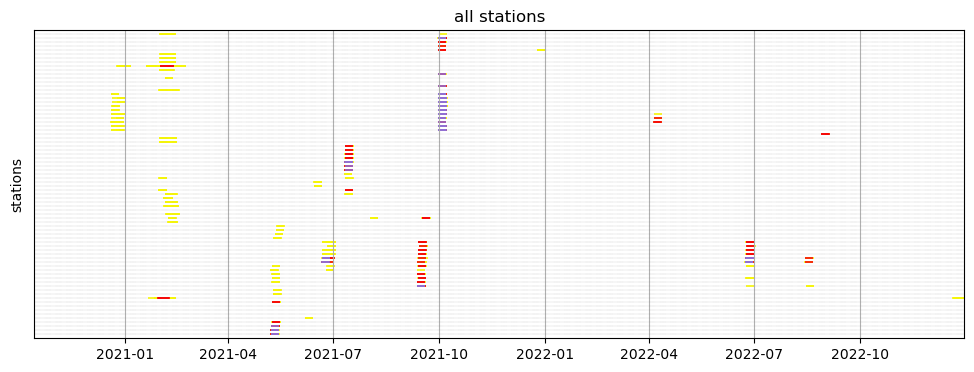

In [7]:
thrs = ['rl2', 'rl5', 'rl20']
figsize = (12, 4)
exceedances_timeline(dis_cat, stn_cat, thresholds=thrs, figsize=figsize, grid=True, title='all stations')

There have been three major flood events in the catchemnt during the last 2 years: September 2021, December 2021, and January 2022. The extent of the floods can be seen by the number of stations affected. This is a example of the correlation in which we would incur if we use those sets of stations in the suceeding analysis. The correlation filter, nevertheless, (last plot) removed most of this correlation. However, there have been minor flood events that affected only one or two stations (December 2022, for instance).

### 2.2 Events exceeding Q5

I will count the number of events that exceeded the 5-year return period. I have created a function call `identify_events` that does it. I have also created other two plotting functions (`plot_events_map`, `plot_events_timeseries`) to inspect the results.

no. stations with at least one event:	44
total no. of events:			59


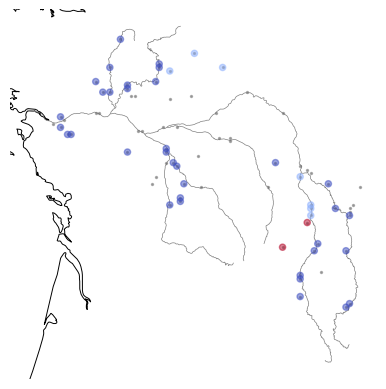

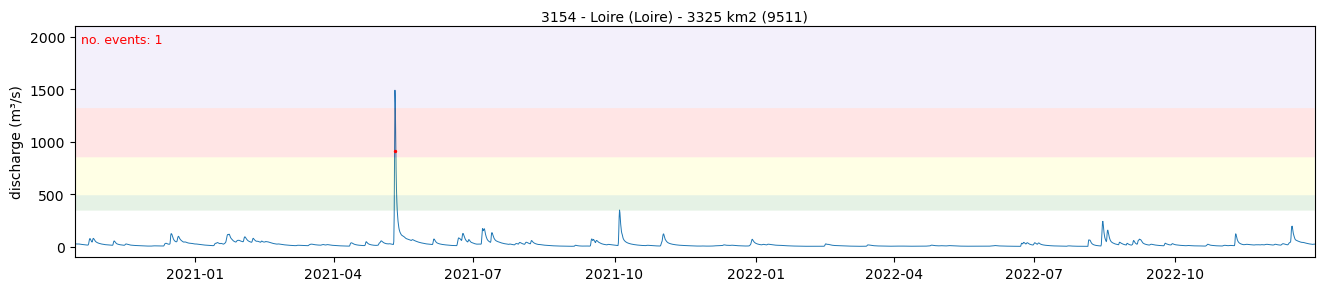

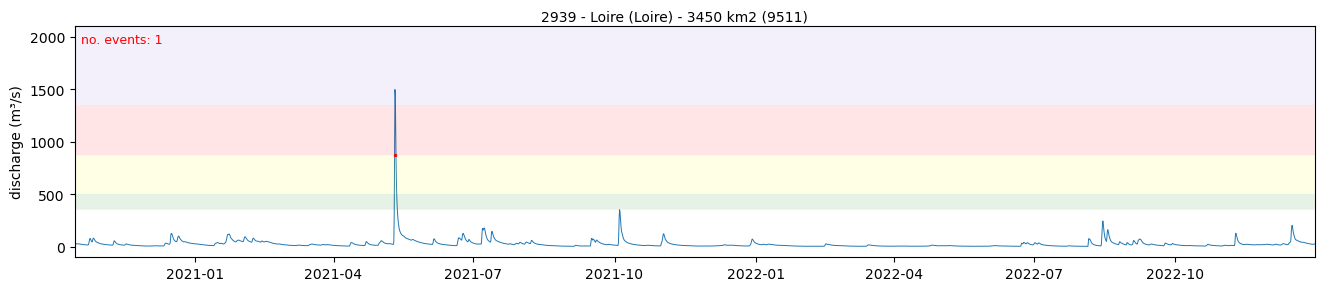

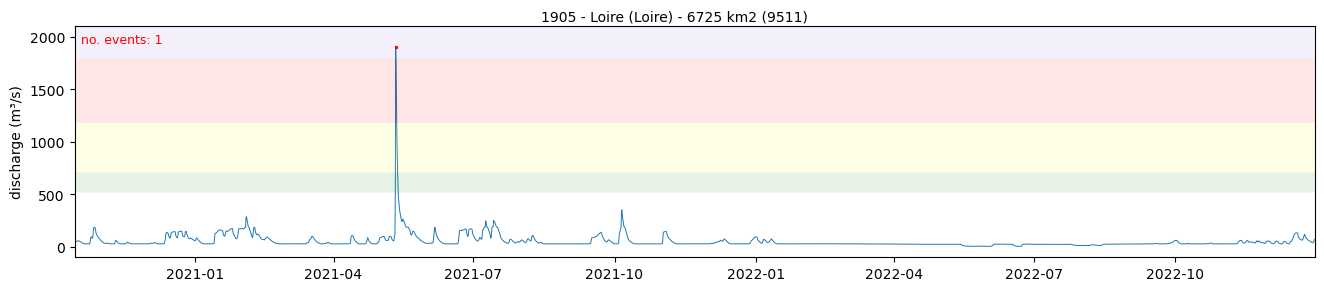

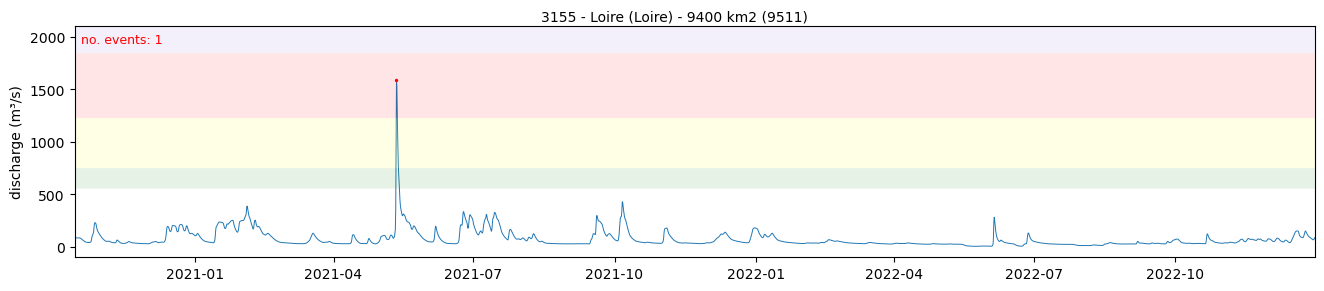

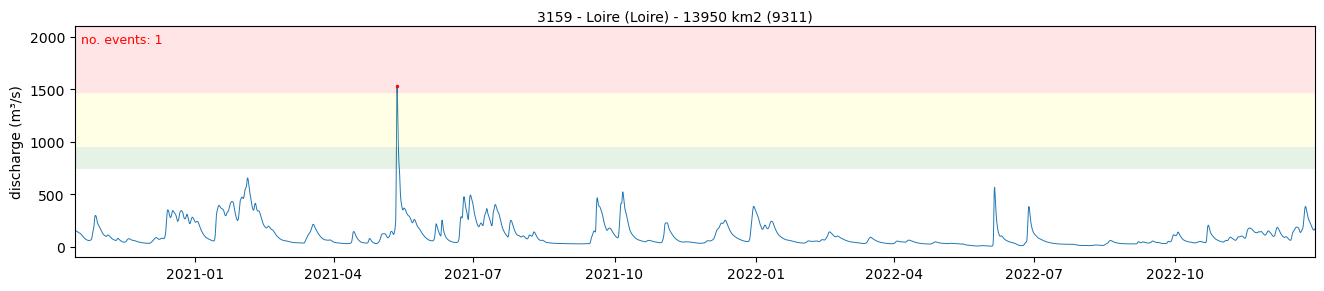

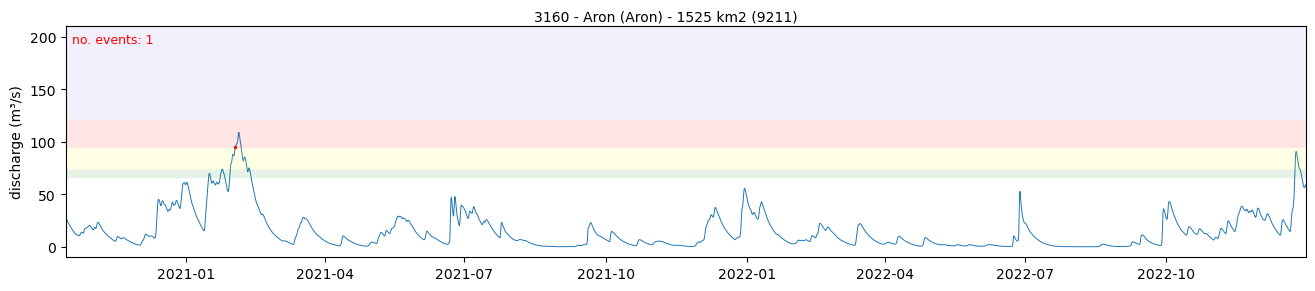

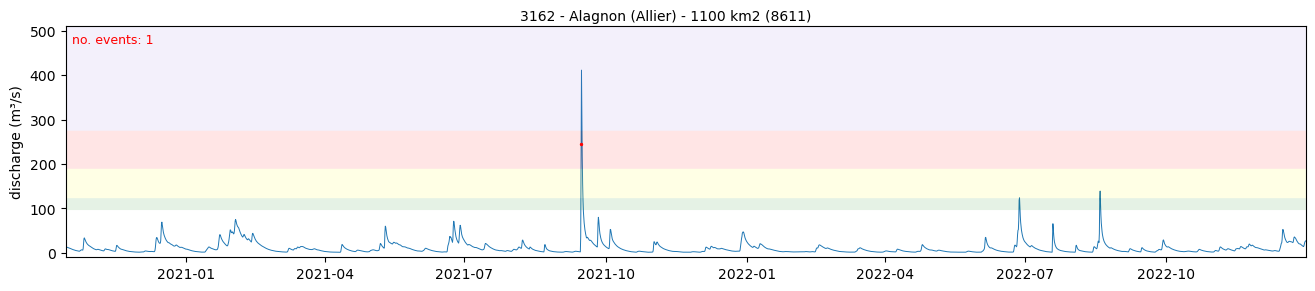

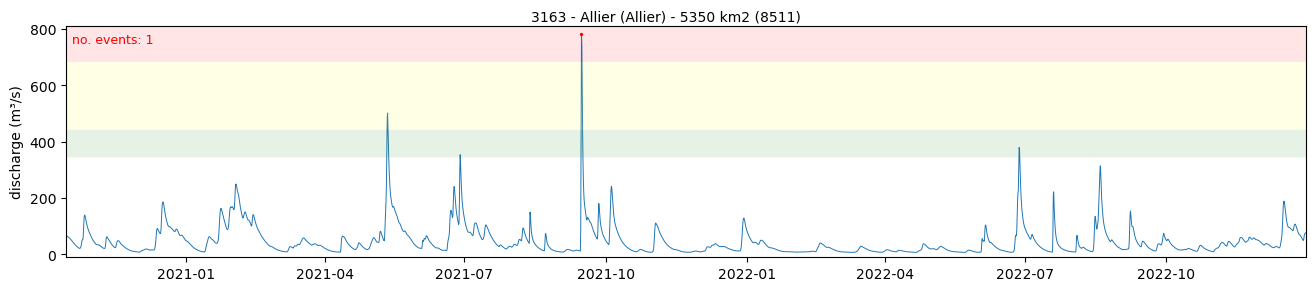

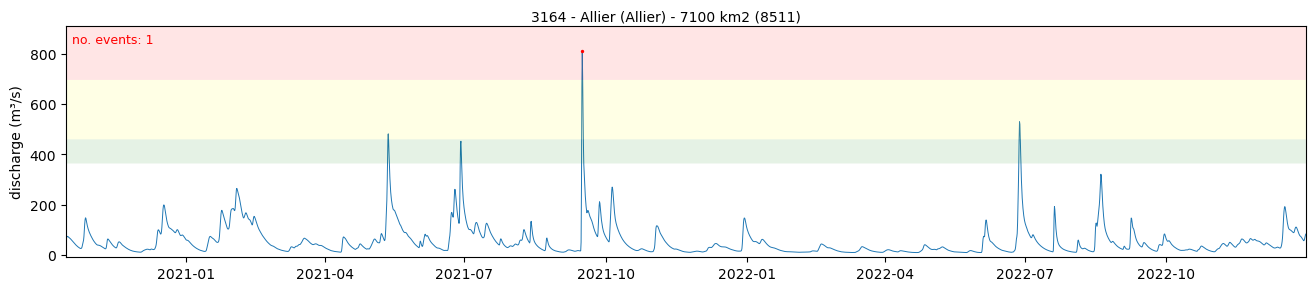

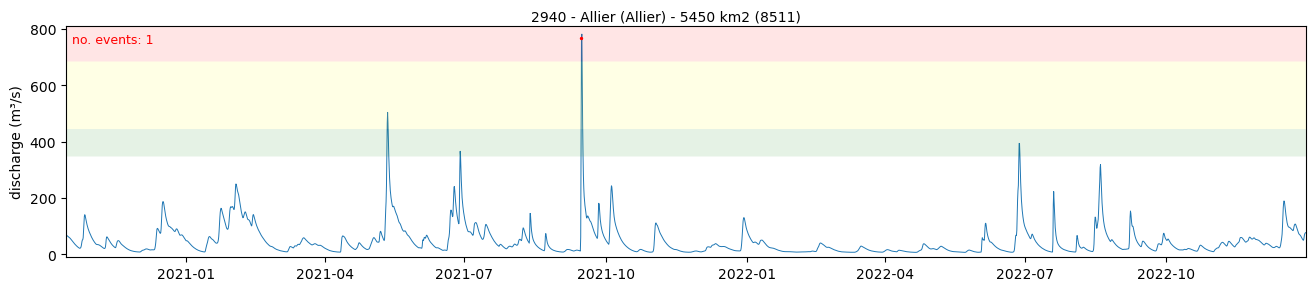

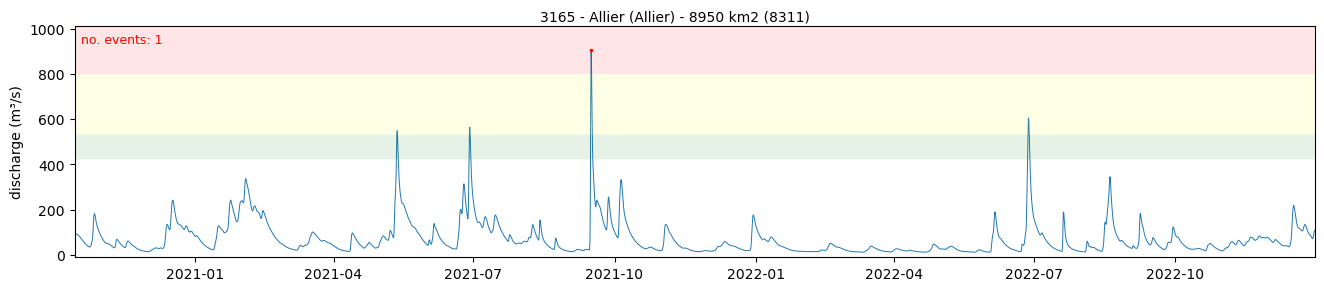

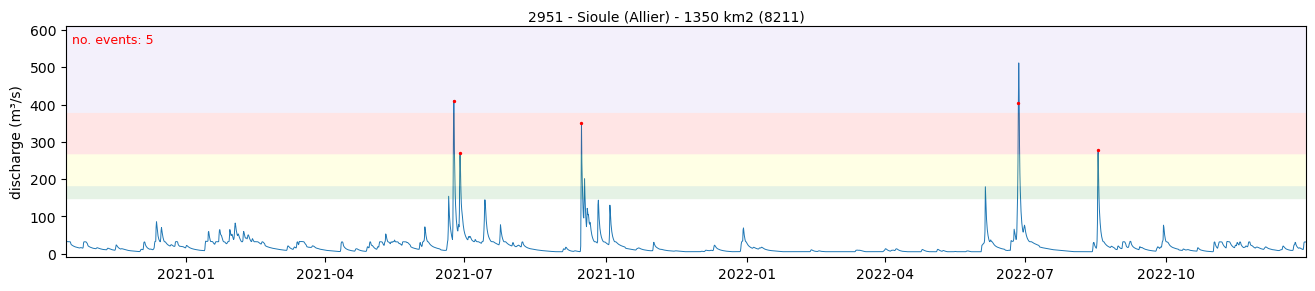

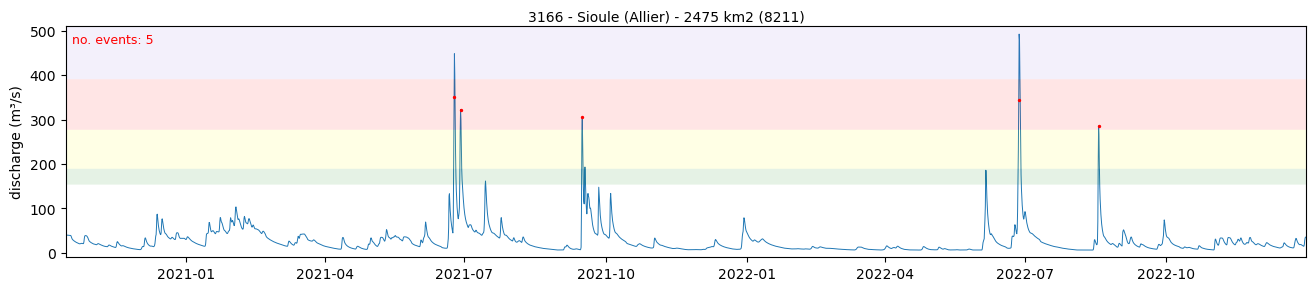

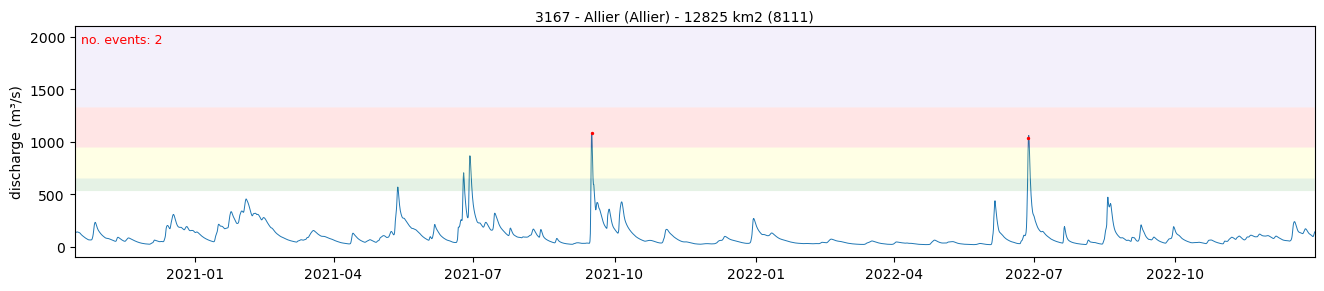

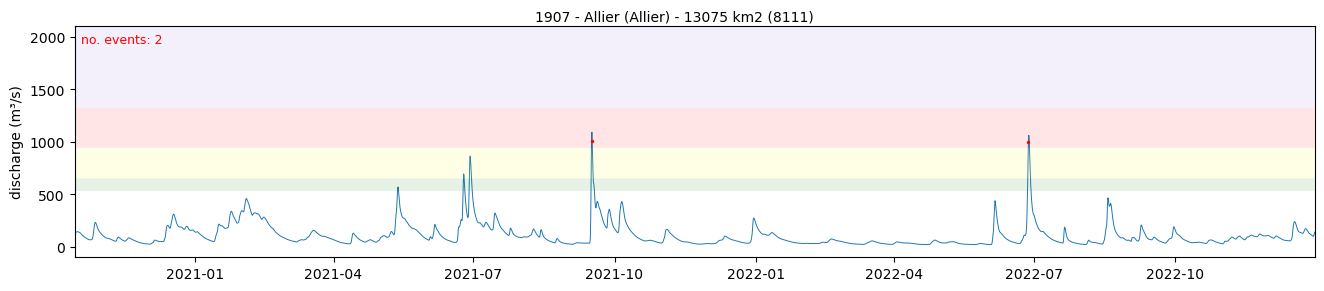

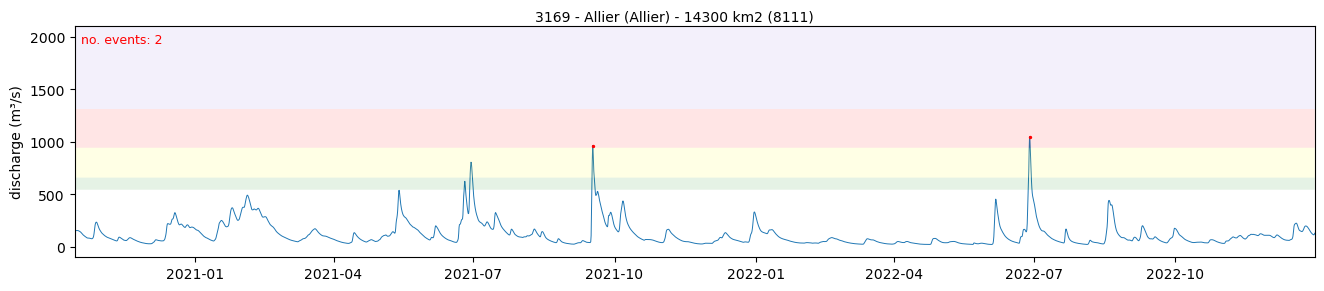

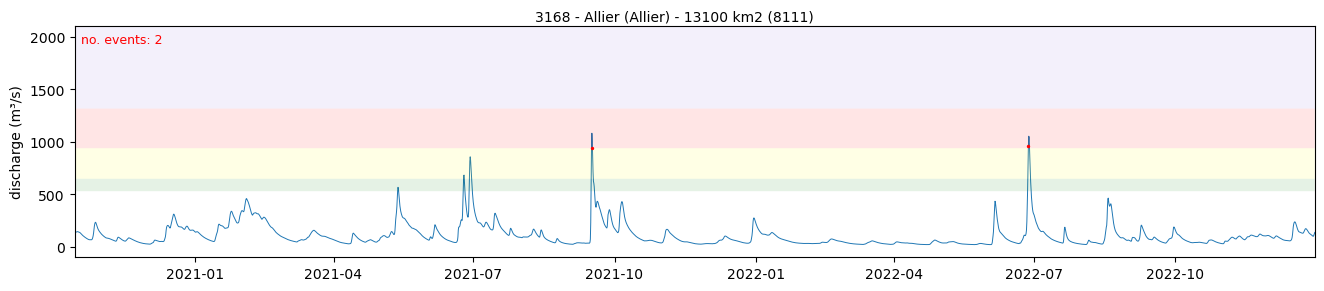

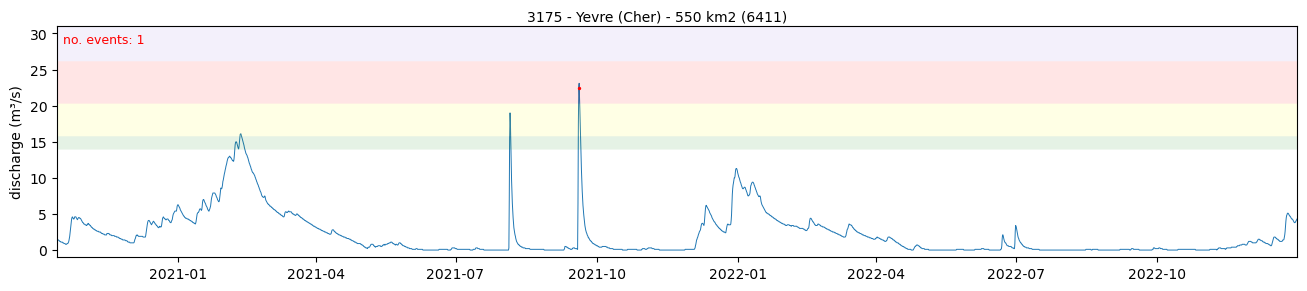

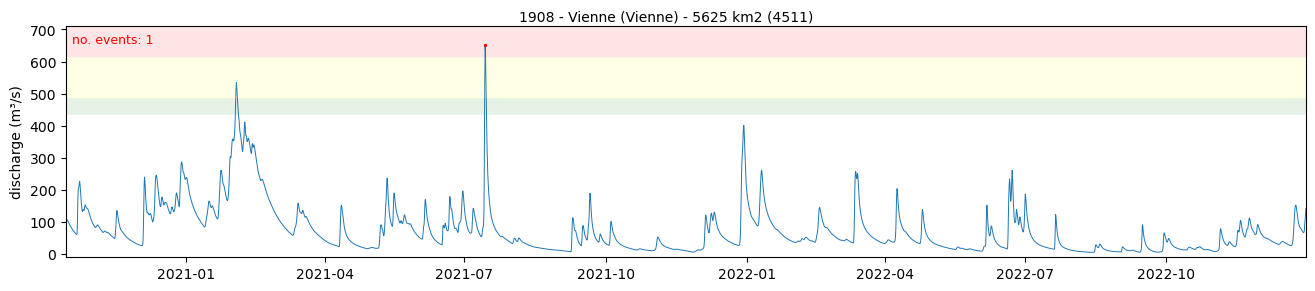

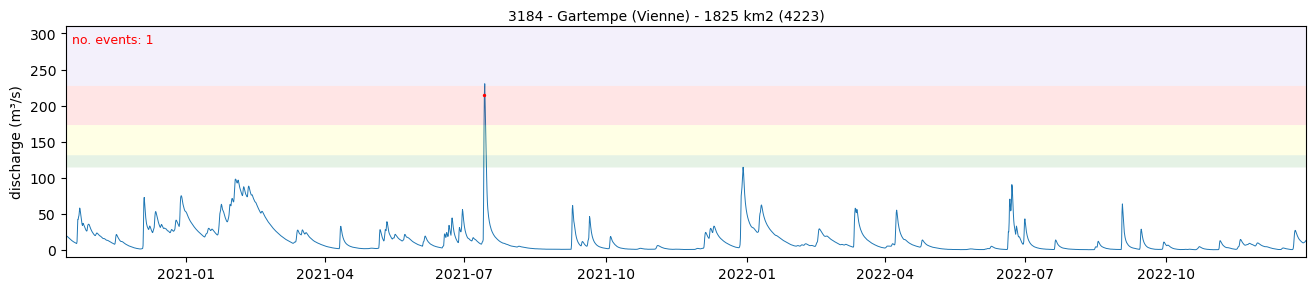

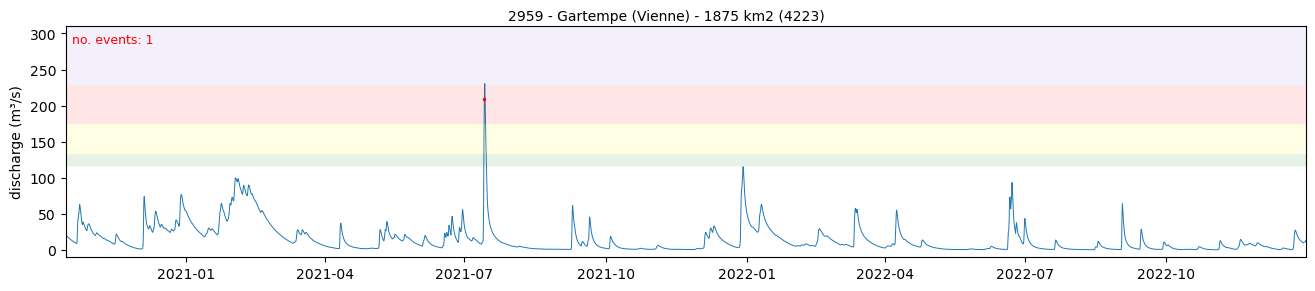

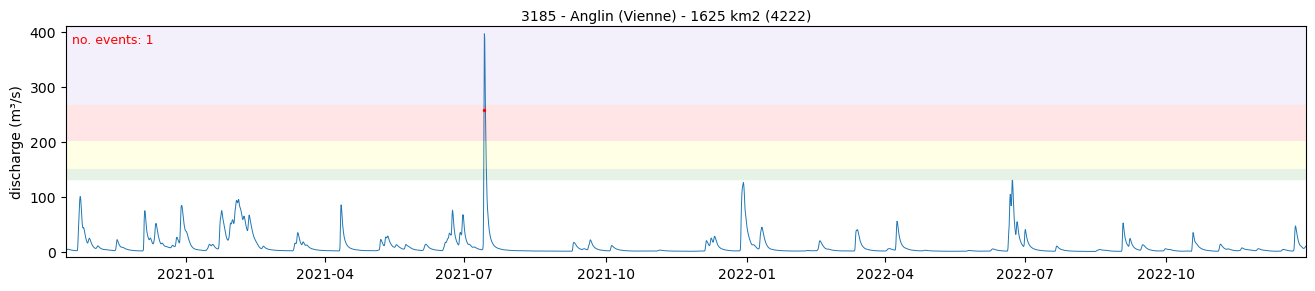

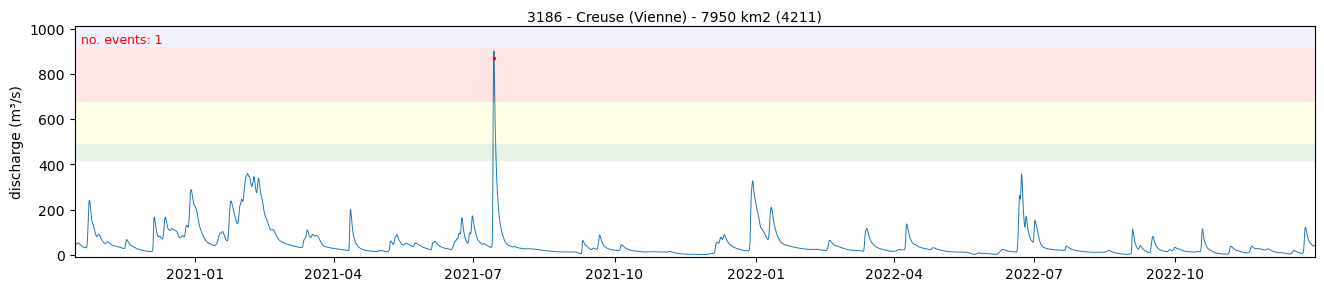

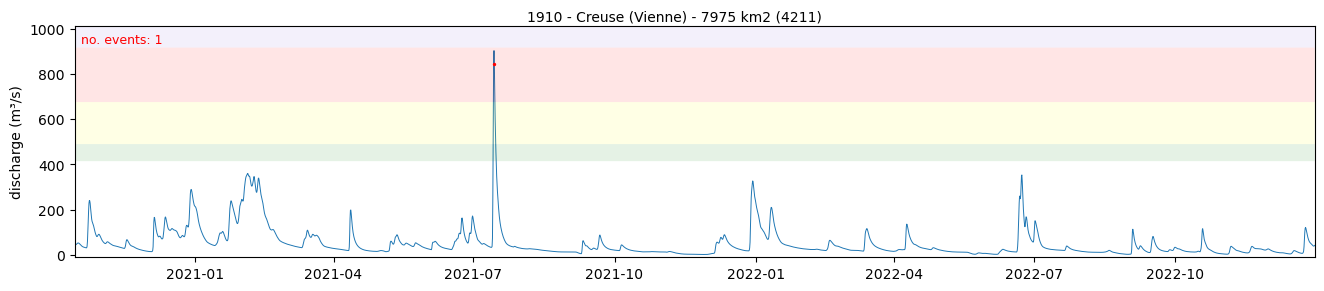

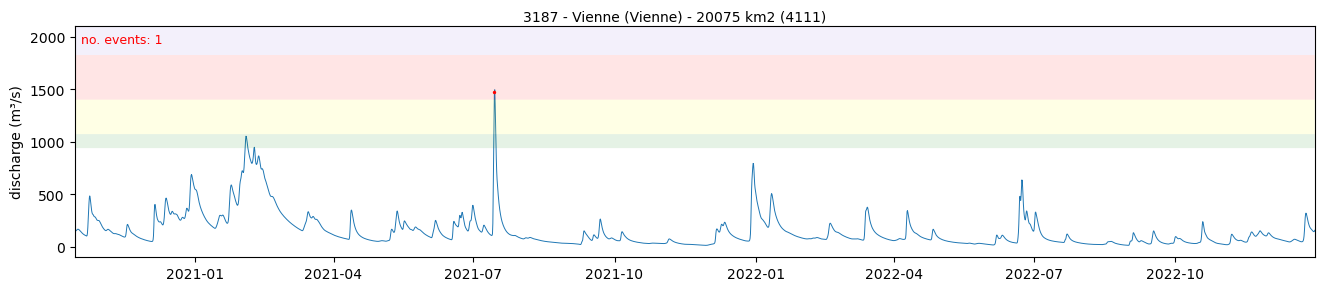

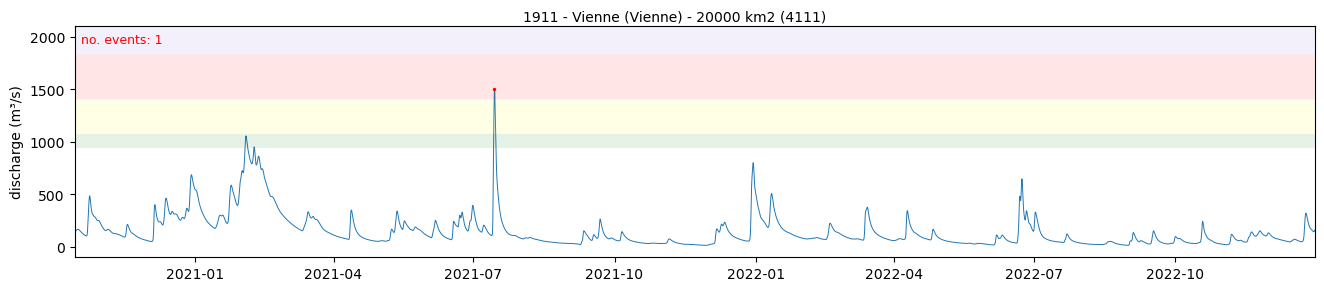

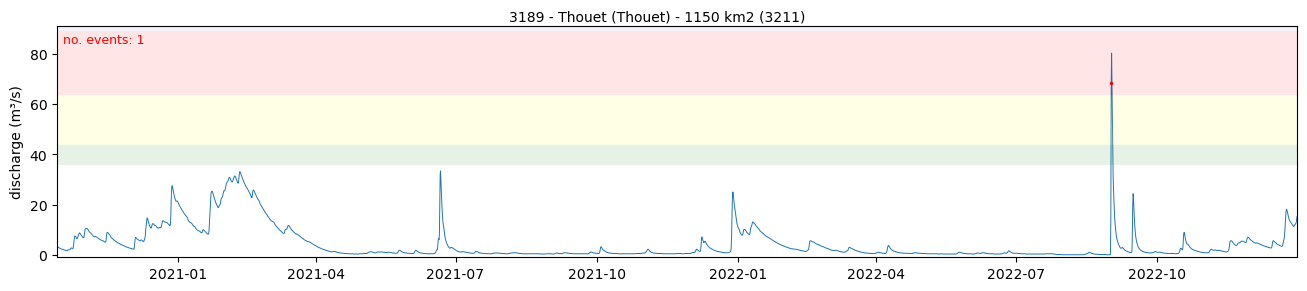

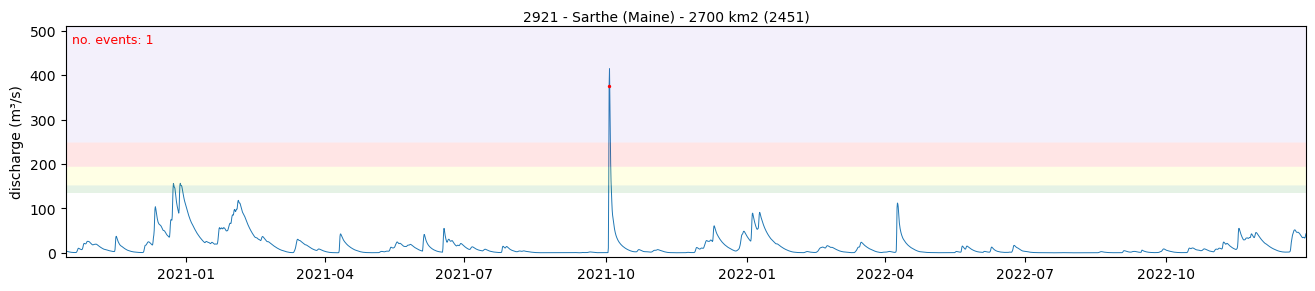

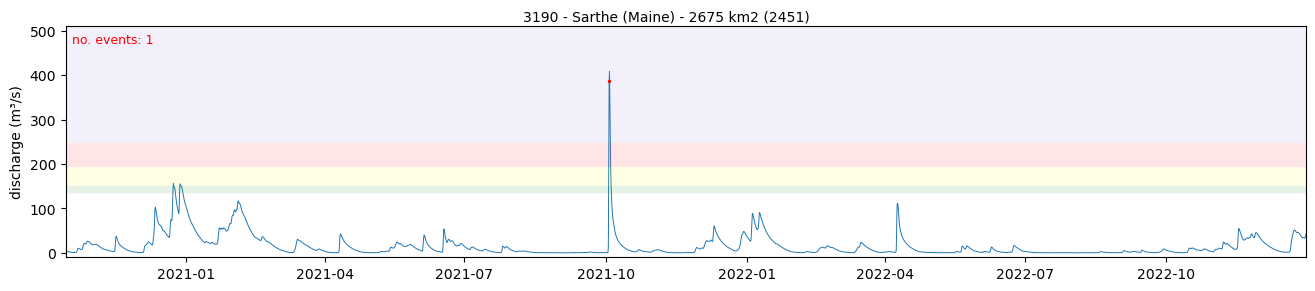

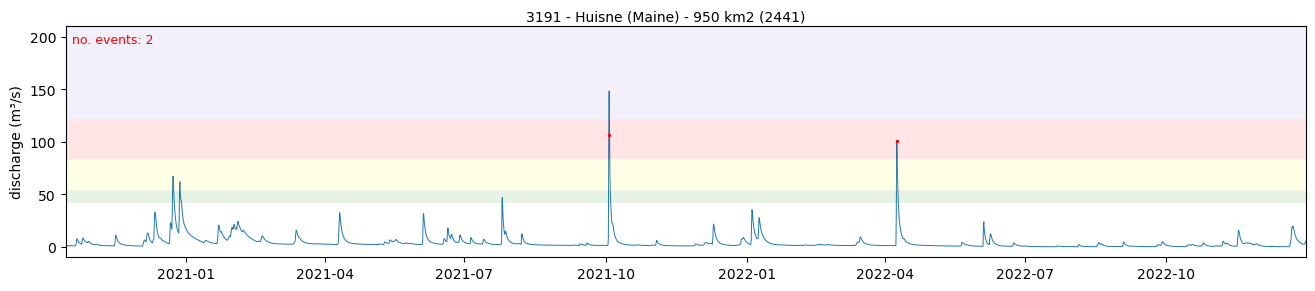

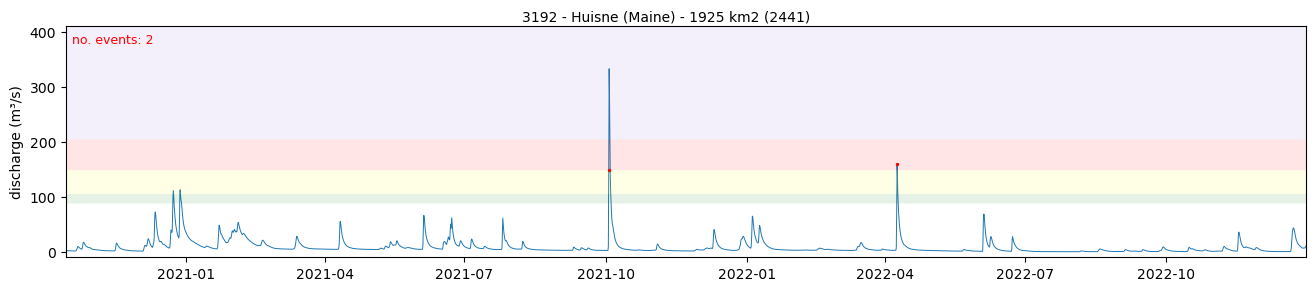

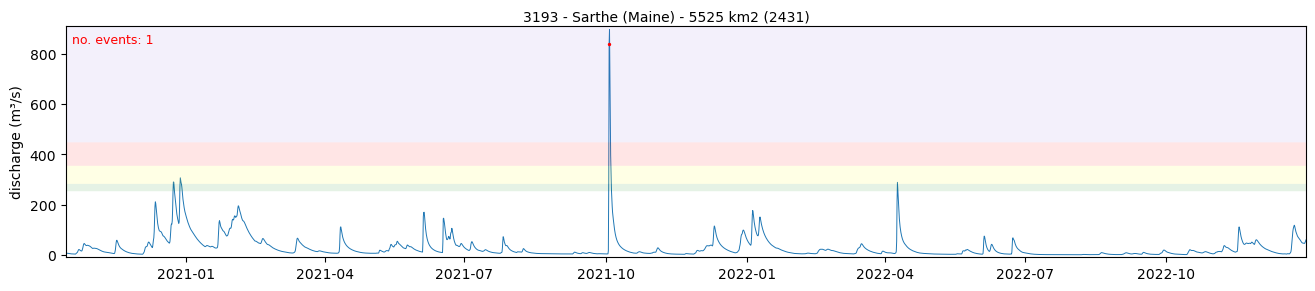

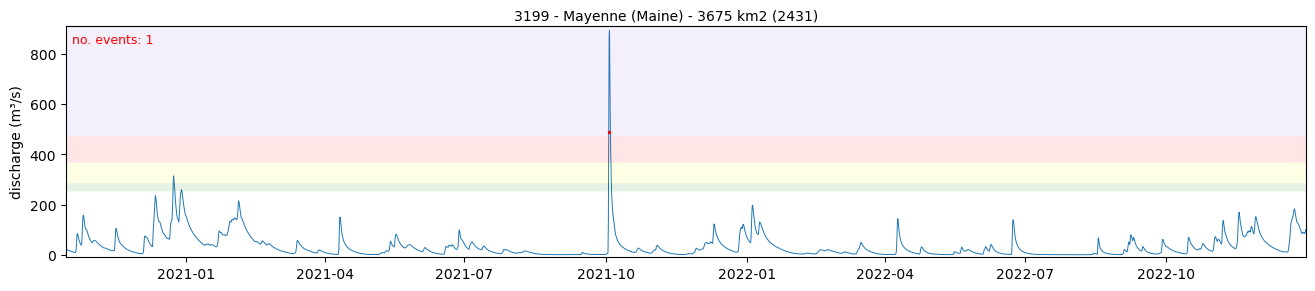

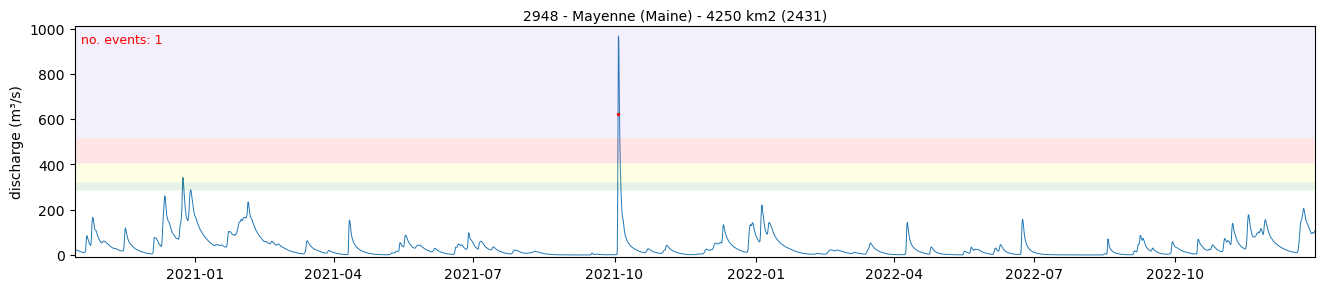

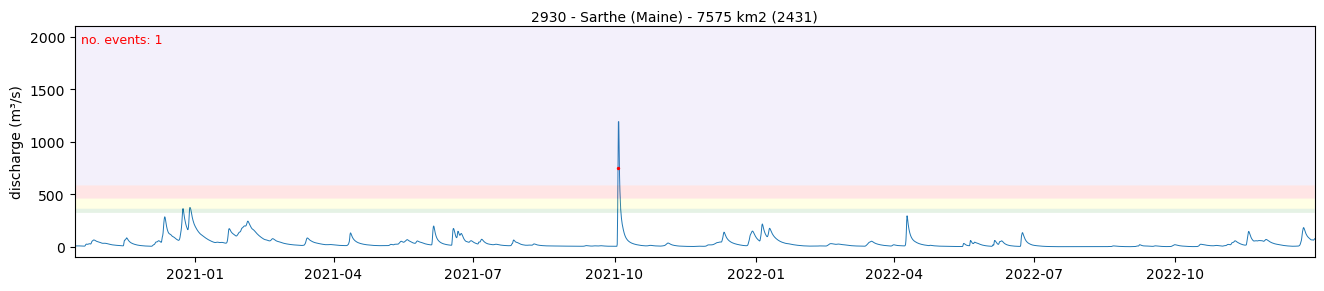

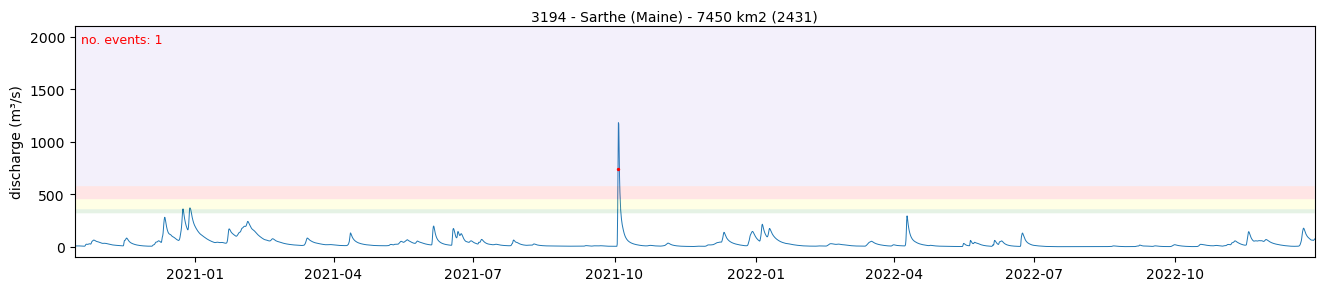

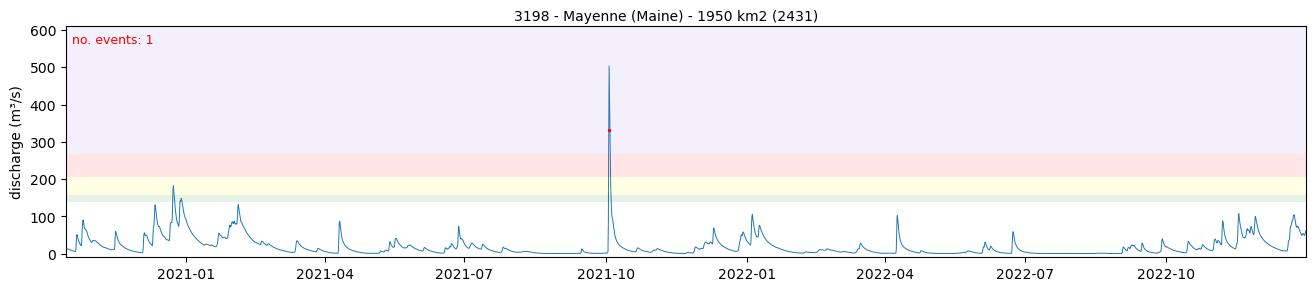

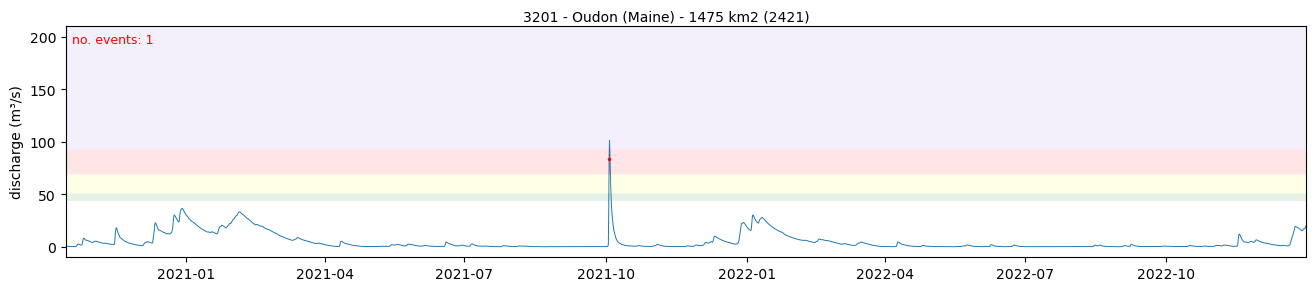

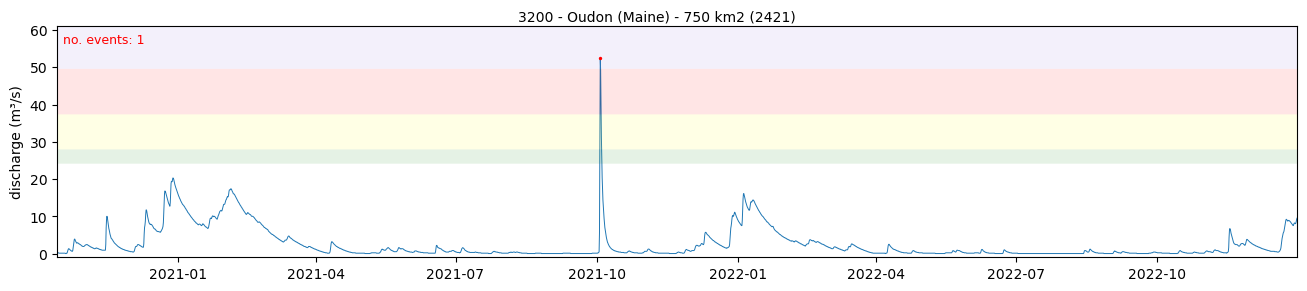

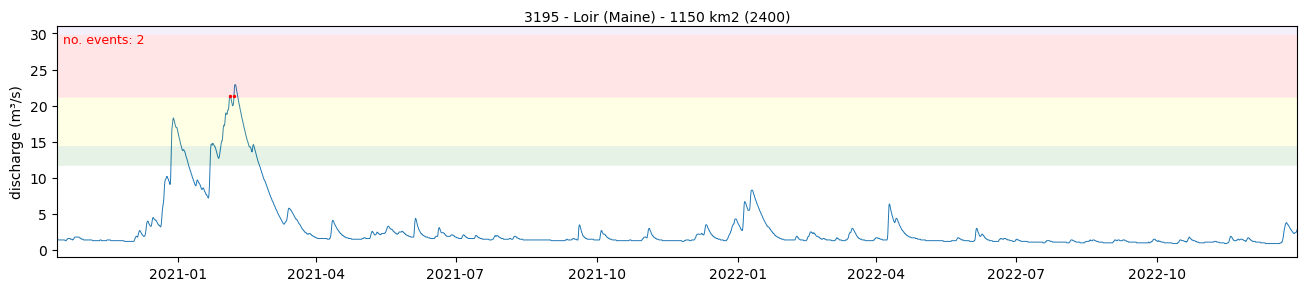

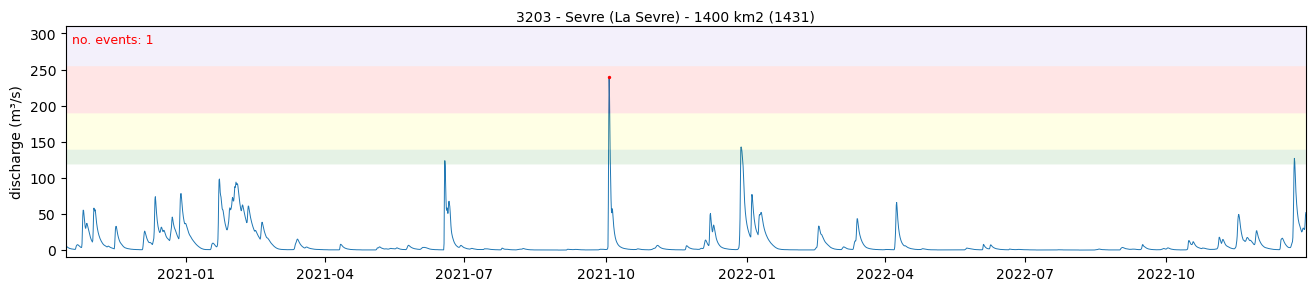

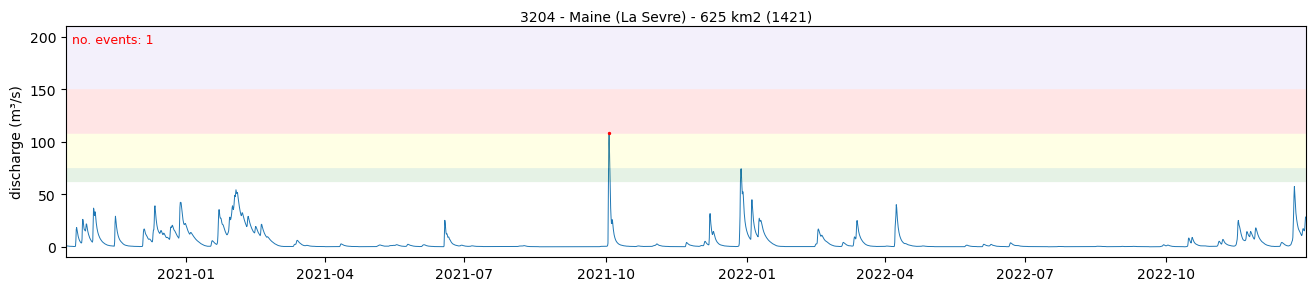

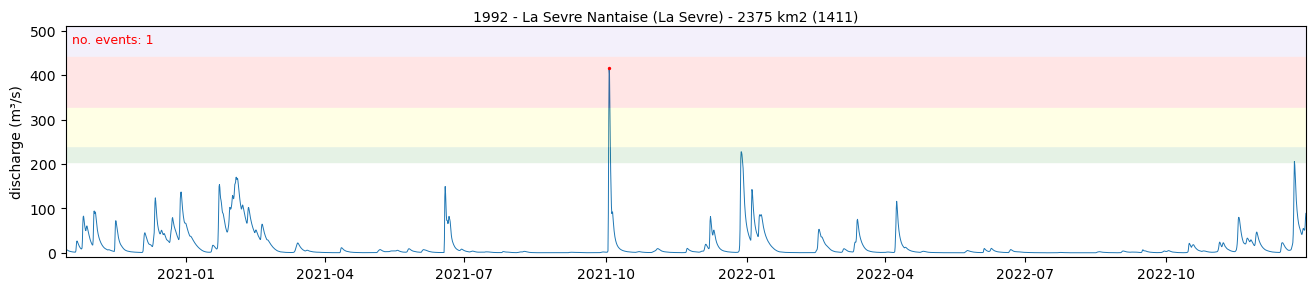

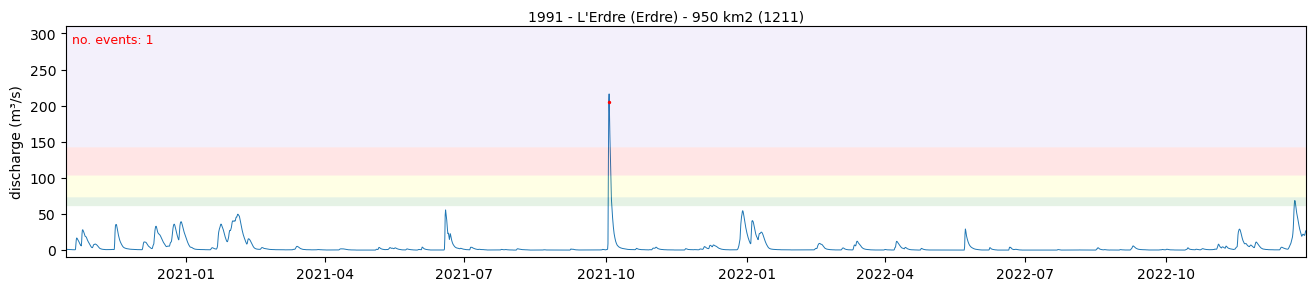

In [8]:
# return period
rp = 5

# IDENTIFY EVENTS
# ---------------

# identify events only with upper bound
events = identify_events(dis_cat, stn_cat[f'rl{rp}'])

# count number of events per station
col = f'n_events_{rp}'
stn_cat[col] = events.sum()
print('no. stations with at least one event:\t{0}'.format((stn_cat[col] > 0).sum()))
print('total no. of events:\t\t\t{0}'.format(stn_cat[col].sum()))

# PLOT MAP
# --------

out_folder = f'results/{catchment}/no_events/{rp}/'
if os.path.exists(out_folder) is False:
    os.makedirs(out_folder)
plot_events_map(stn_cat.X, stn_cat.Y, stn_cat[col], rivers=rivers_shp, size=20, save=f'{out_folder}/no_events_map.png')

# PLOT TIMESERIES
# ---------------

# Select the stations in a catchment
mask = stn_cat[col] > 0
stns = stn_cat.loc[mask].index#.sort_values(['subcatchment_order', 'strahler']).index
# plot timeseries 
for stn in stns:
    title = '{0} - {1} ({2}) - {3:.0f} km2 ({4:.0f})'.format(stn, *stn_cat.loc[stn, ['river', 'subcatchment', 'area', 'pfafstetter']])
    plot_events_timeseries(dis_cat[stn], events[stn], thresholds=stn_cat.loc[stn, ['rl1.5', 'rl2', 'rl5', 'rl20']],
                           title=title, save=f'{out_folder}/no_events_{stn}.png')

43 out of the 99 points in the Ebro basin registered a flood event in the last 2 years, to sum up a total of 68 events. As can be seen in the timeseries, some of the stations have so similar discharge series that the events they registerd should be considered as the same.

Out of curiosity, let's see how many events were registered in every subcatchment and every river.

In [9]:
# no. events per subcatchment
event_subcat = stn_cat.groupby('subcatchment')[col].sum().sort_values(ascending=False)
event_subcat[event_subcat > 0]

subcatchment
Allier      23
Maine       16
Vienne       8
Loire        5
La Sevre     3
Aron         1
Cher         1
Erdre        1
Thouet       1
Name: n_events_5, dtype: int64

In [10]:
# no. events per river
event_riv = stn_cat.groupby('river')[col].sum().sort_values(ascending=False)
event_riv[event_riv > 0]

river
Allier               12
Sioule               10
Loire                 5
Sarthe                5
Huisne                4
Vienne                3
Mayenne               3
Creuse                2
Oudon                 2
Gartempe              2
Loir                  2
Alagnon               1
Thouet                1
Sevre                 1
Maine                 1
La Sevre Nantaise     1
L'Erdre               1
Aron                  1
Anglin                1
Yevre                 1
Name: n_events_5, dtype: int64

## 3 Select stations in the catchment 

Originally, there's 99 stations in the Ebro catchment. However, we shouldn't use all of them in the following analyses, because some of them will be highly correlated. In the following sections I will create subsets of this list of stations applying diverse procedures.

### 3.1 Spearman correlation

To take into account correlation between stations in different rivers, I compute the Spearman correlation coefficient between all the discharge timeseries in the catchment. Afterwards, I remove one of  stations (the one upstream) from each pair  of highly correlated stations. I will consider that 2 stations are highly correlated when their Spearman correlation coefficient is higher than a predefined threshold.

> I apply the Spearman correlation coefficient, instead of the Pearson, because it is insensitive to non linearities.

In [11]:
# correlation threshold
rho = .9

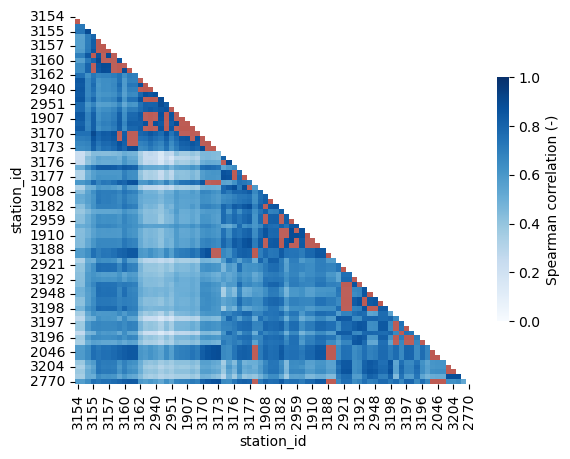

In [12]:
# correlation matrix
corr = dis_cat.corr(method='spearman')
# keep only upper diagonal
corr = filter_correlation_matrix(corr, rho=None)

# compute exceedance of the correlation threshold
highly_correlated = corr > rho
highly_correlated = highly_correlated.astype(int)
highly_correlated[highly_correlated == 0] = np.nan

# plot
sns.heatmap(corr, vmin=0, vmax=1, cmap='Blues', cbar_kws={'label': 'Spearman correlation (-)', 'shrink': .66});
sns.heatmap(highly_correlated, cmap='Reds', vmin=0.5, vmax=1.5, alpha=.75, cbar=None);

In the previous correlation matrix we can check that there are several points with a highly correlated discharge timeseries (in red). It is specially noticeable in the last few points (bottom right), which probably correspond to points in the Ebro river, since stations are sorted by subcatchment, river and area.

I'm curious about what rivers are highly correlated. For each station with at least one correlation higher than the threshold, I will print its ID, river and the name of the rivers to which its highly correlated stations belong. I want to check whether rivers far apart in the catchment or only close by rivers show correlation.

In [13]:
# print rivers highly correlated to each point
for stn in corr.index:
    exc = corr.loc[stn] > rho
    if exc.any(): # i
        stns_corr = stn_cat.loc[exc]
        rivers = stns_corr.river.unique()
        if len(rivers) > 1:
            print(stn, stn_cat.loc[stn, 'river'], rivers, sep='\t')

3159	Loire	['Loire' 'Arroux']
3161	Loire	['Loire' 'Arroux' 'Aron']
1913	Loire	['Loire' 'Arroux']
2940	Allier	['Alagnon' 'Allier']
3167	Allier	['Allier' 'Sioule']
1907	Allier	['Allier' 'Sioule']
3168	Allier	['Allier' 'Sioule']
3170	Loire	['Loire' 'Allier']
3171	Loire	['Loire' 'Allier']
2959	Gartempe	['Vienne' 'Gartempe']
3186	Creuse	['Vienne' 'Creuse' 'Gartempe']
1910	Creuse	['Vienne' 'Creuse']
3187	Vienne	['Vienne' 'Gartempe' 'Creuse']
1911	Vienne	['Vienne' 'Gartempe' 'Creuse']
3193	Sarthe	['Sarthe' 'Huisne']
2948	Mayenne	['Sarthe' 'Mayenne']
3198	Mayenne	['Sarthe' 'Mayenne']
1992	La Sevre Nantaise	['Sevre' 'Maine']


There's a cluster of correlated stations in the Aragon river and its tributaries: Arga (Araquil), Esca and Irati. The Ega and Zadorra rivers, close to the the Aragon, belong also to this group of stations. More interestingly, there are stations in the Ebro river that belong to this cluster.

There's a second cluster of correltaed stations in the rivers Noguera Pallaresa, Esera and Noguera Ribagorzana (all of them rivers in the Segre subcatchment).

no. original points in the Loire catchment:	76
no. filtered points in the Loire catchment:	29


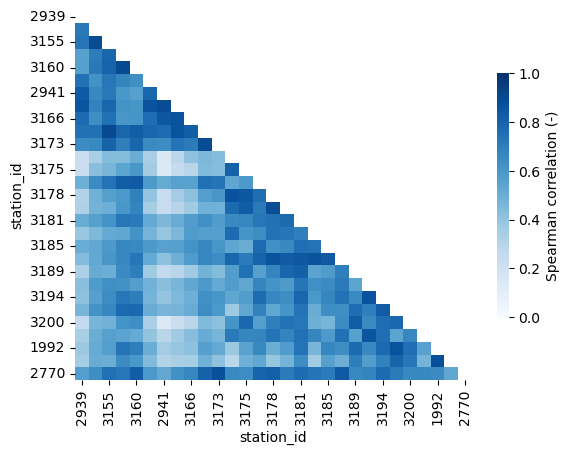

In [14]:
# remove highly correlated stations
corr_ = filter_correlation_matrix(corr, rho=.9)
stn_cat_2 = stn_cat.loc[corr_.index]
        
# plot correlation matrix
sns.heatmap(corr_, vmin=0, vmax=1, cmap='Blues',
            cbar_kws={'label': 'Spearman correlation (-)', 'shrink': .66});

print('no. original points in the {0} catchment:\t{1}'.format(catchment, stn_cat.shape[0]))
print('no. filtered points in the {0} catchment:\t{1}'.format(catchment, stn_cat_2.shape[0]))

Applying this procedure has removed nearly a  half of the stations.

> <font color='firebrick'> Does it make any sense to apply the procedure first river-wise and then to the whole set of stations?</font>

### 3.2 Correlation sorted event-wise

After analysis further results from the correlation filtering, I found out that no importance is given to the number of events registered. This means that stations upstream with events may have been removed in benefit of stations downstream where no events were registered.

I will resort the station data in an ascending order in terms of number of events and reapply the correlation filtering.

In [15]:
# sort stations according to number of flood events
stn_cat_3 = stn_cat.copy()
stn_cat_3.sort_values([col], ascending=True, inplace=True)

no. original points in the Loire catchment:	76
no. filtered points in the Loire catchment:	27


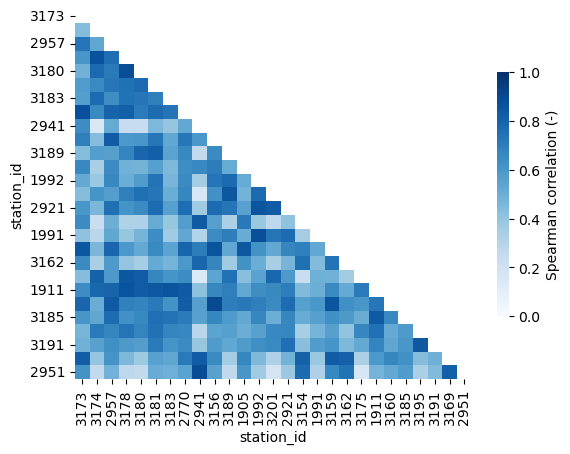

In [16]:
# correlation matrix
corr_3 = dis_cat[stn_cat_3.index.to_list()].corr(method='spearman')
# remove highly correlated stations
corr_3 = filter_correlation_matrix(corr_3, rho=rho)
stn_cat_3 = stn_cat_3.loc[corr_3.index]

print('no. original points in the {0} catchment:\t{1}'.format(catchment, stn_cat.shape[0]))
print('no. filtered points in the {0} catchment:\t{1}'.format(catchment, stn_cat_3.shape[0]))

sns.heatmap(corr_3, vmin=0, vmax=1, cmap='Blues',
            cbar_kws={'label': 'Spearman correlation (-)', 'shrink': .66});

The outcome is 2 more stations than when the station sorting was done basically on gegraphical location.

## 4 Summary

So far I have created 5 sets of stations:

* The complete set of stations that fulfil the initial criteria.
* A subset based on area increment.
* A subset based on correlation between stations sorted by geographical location.
* A subset based on correlation between stations sorted by the number of flood events.
* A subset based on high-flow correlation between stations sorted by the number of flood events.

In [17]:
stn_sets = {'all': stn_cat,
            'correlation_geographically-sorted': stn_cat_2,
            'correlation_event-sorted': stn_cat_3}

# sort all subsets equally
for key, stns in stn_sets.items():
    stns.sort_values(['area'], ascending=True, inplace=True)
    stns.sort_values('pfafstetter', ascending=False, inplace=True)

Let's see how many stations, events and what's the geographical distribution across the catchment.

                                  no_stations p_stations_event no_events
all                                        76         0.578947        59
correlation_geographically-sorted          29          0.62069        24
correlation_event-sorted                   27          0.62963        24


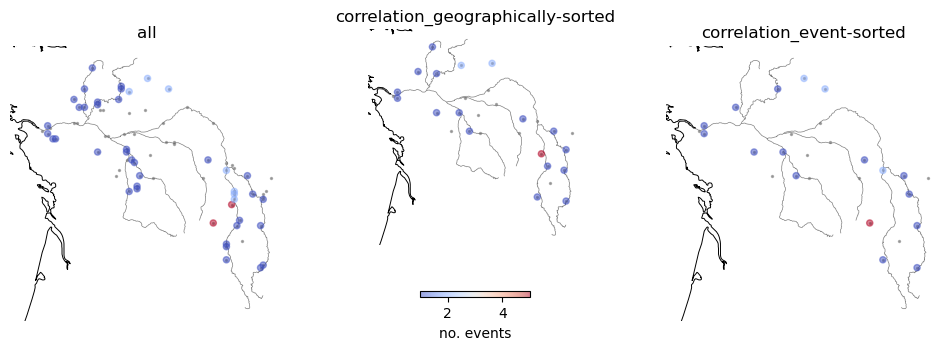

In [22]:
# table summarizing no. stations and events with every station set
summary = pd.DataFrame(index=stn_sets.keys(), columns=['no_stations', 'p_stations_event', 'no_events'])
for i, (key, stns) in enumerate(stn_sets.items()):
    summary.loc[key] = stns.shape[0], sum(stns[col] > 0), stns[col].sum()
summary.p_stations_event /= summary.no_stations
print(summary)

# plot maps of no. events for each of the station sets
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000,
                                          globe=ccrs.Globe(ellipse='GRS80'))
nrows = 1
ncols = int(np.ceil(len(stn_sets) / nrows))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), 
                         subplot_kw={'projection': proj})

for ax, (key, stns) in zip(axes.flatten(), stn_sets.items()):
    plot_events_map(stns.X, stns.Y, stns[col], rivers=rivers_shp, size=20, ax=ax, title=key)

plt.colorbar(plot_events_map.colorbar, location='bottom', shrink=.4, label='no. events', ax=axes[1]);

The previous graph shows how the selection of stations affects the number of stations and flood events. 

**Correlation geographically-sorted**

The filter based on correlation is by far more restritive than that based on area increment. Whereas the latter only removed a few stations, the former removed more than half of them. The drawback of the correlation filter is that some rivers don't have any point any more. For instance, in the Aragon subcatchment there is a station with 3 flood events in the Irati river that was removed because of its correlation. All the stations in the Najerilla river where also filtered out, even though they both had flood events. The proportion of stations with events has been reduced to 0.3.

**Correlation event-sorted**

This procedure has improved the selection of stations, even though the number of flood events has only slightly increased (from 23 to 29). However, some of the issues earlier mentioned have been solved; namely, now there's one station in the Irati and the Najerilla rivers.

> <font color='firebrick'>**The order of the stations before the correlation selection is vital for the outcome.**</font>

I will now plot the timelines of flood events with all the subsets of stations, to check if we lose track of some sparse flood evetns.

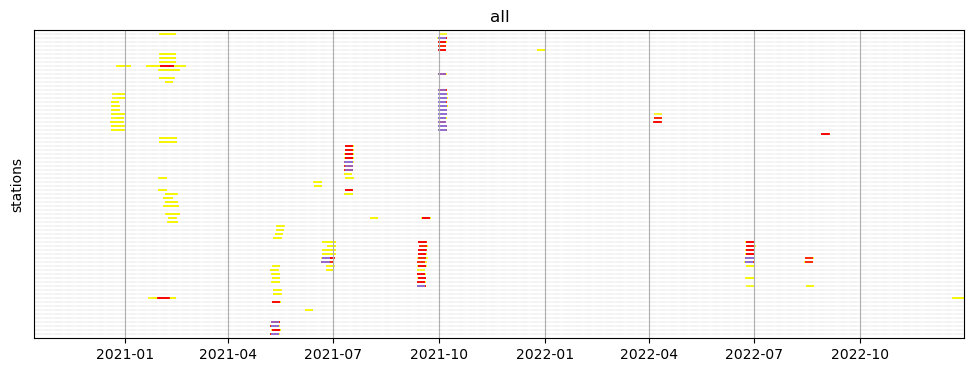

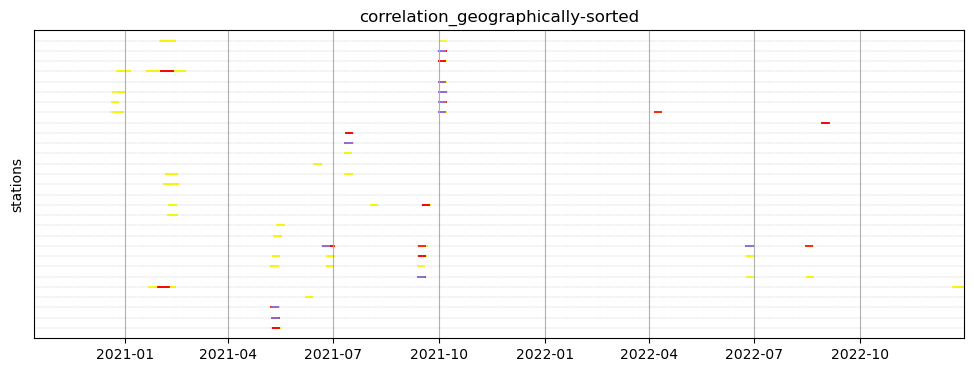

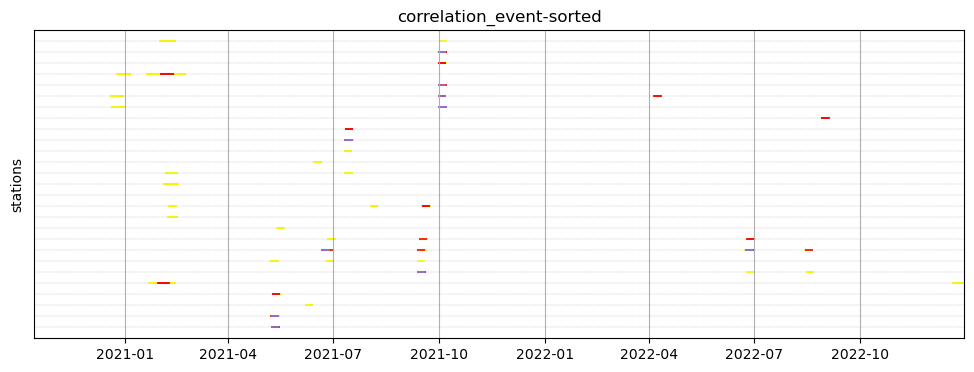

In [23]:
thrs = ['rl2', 'rl5', 'rl20']
figsize = (12, 4)
for key, stns in stn_sets.items():
    exceedances_timeline(dis_cat, stns, thresholds=thrs, figsize=figsize, grid=True, title=key)

The three main events can be found in all the subsets. Subsets 2 and 3, with far less stations, have removed most of the collinearity among stations, so each of this event is represented in less stations.

At this point, I'm mostly interested in the minor flood events that affected only one or two stations (December 2022, for instance). These events can be seen in the two subsets with a larger number of stations (1 and 4). However, they are lost in subset 2 (correlation geographically sorted) because the correlation filter has removed so many stations that some events are lost. This is important, because these minor events could be false alarms that should be included in the analysis. Hopefully, subset 3 (correlation event-sorted) keeps all but of of these events; only a event at the very beginning of the study period is lost. However, this subset misses the event from January 2021 in the headwaters.

Therefore, the selection procedure that keeps most of the events and is able to remove part of the collinearity is the one based on correlation when stations are sorted base on the number of events.

As a final check, I will print a table with the number per river for each the subsets of stations.

In [34]:
n_stn_sub = pd.DataFrame(dtype=float)
for key, stns in stn_sets.items():
    n_stn_sub = pd.concat((n_stn_sub, stns.subcatchment.value_counts()), axis=1)
n_stn_sub.columns = stn_sets.keys()

n_stn_sub

all  correlation_geographically-sorted  correlation_event-sorted
Loire      20                                8.0                       7.0
Maine      17                                5.0                       4.0
Allier     12                                4.0                       4.0
Vienne     12                                4.0                       4.0
Cher        6                                4.0                       4.0
Arroux      3                                NaN                       NaN
La Sevre    3                                1.0                       1.0
Aron        1                                1.0                       1.0
Thouet      1                                1.0                       1.0
Erdre       1                                1.0                       1.0

The two selections based on correlation has removed all the stations from some rivers, so we would lose some spatial coverage. Fortunately, when sorted by the number of events, the method that proved better, we only lose stations in 3 minor rivers (Iregua, Neal, Oca).

In [25]:
# export selected points
stn_sets['correlation_event-sorted'].to_csv(f'results/{catchment}/points_selected.csv')